In [1]:
import numpy as np
import pandas as pd
from glob import glob
from scipy import stats
from pathlib import Path

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

optuna.logging.set_verbosity(optuna.logging.ERROR)

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric

In [2]:
SUB_PATH =  Path("../data/subs/blend")

***
## load data

In [3]:
# lgbm-dart

files = sorted(glob("../data/oof/lgbm-dart-bce-dsv06/oof-*.csv"))[:3]
display(files)
dfs = [pd.read_csv(fn) for fn in files]
df1 = dfs[0][["target"]].copy()

for i,_df in enumerate(dfs):
    df1[f"pred{i}"] = _df["pred"].values
    
df1

['../data/oof/lgbm-dart-bce-dsv06/oof-cv0.csv',
 '../data/oof/lgbm-dart-bce-dsv06/oof-cv1.csv',
 '../data/oof/lgbm-dart-bce-dsv06/oof-cv2.csv']

target     pred0     pred1     pred2
0            0  0.000106  0.000118  0.000120
1            0  0.000788  0.001082  0.000949
2            0  0.000748  0.000940  0.000805
3            0  0.004545  0.003153  0.003067
4            0  0.001512  0.001620  0.001113
...        ...       ...       ...       ...
458908       0  0.003093  0.003760  0.004047
458909       0  0.029627  0.025269  0.039788
458910       0  0.001174  0.001738  0.001076
458911       1  0.112076  0.108932  0.106306
458912       0  0.003344  0.002461  0.001976

[458913 rows x 4 columns]

In [4]:
# lgbm-dart-xtree

files = sorted(glob("../data/oof/lgbm-dart-xtree-bce-dsv06/oof-*.csv"))[:3]
display(files)
dfs = [pd.read_csv(fn) for fn in files]
df2 = dfs[0][["target"]].copy()

for i,_df in enumerate(dfs):
    df2[f"pred{i}"] = _df["pred"].values
    
df2

['../data/oof/lgbm-dart-xtree-bce-dsv06/oof-cv0.csv',
 '../data/oof/lgbm-dart-xtree-bce-dsv06/oof-cv1.csv',
 '../data/oof/lgbm-dart-xtree-bce-dsv06/oof-cv2.csv']

target     pred0     pred1     pred2
0            0  0.000209  0.000190  0.000235
1            0  0.001212  0.001255  0.001198
2            0  0.001043  0.000911  0.000824
3            0  0.003490  0.004013  0.003008
4            0  0.002004  0.001528  0.002035
...        ...       ...       ...       ...
458908       0  0.003667  0.003631  0.004184
458909       0  0.031423  0.039790  0.028722
458910       0  0.002141  0.002401  0.001492
458911       1  0.101202  0.092303  0.097897
458912       0  0.002416  0.001867  0.002314

[458913 rows x 4 columns]

In [ ]:
# lgbm-dart-linear

#files = sorted(glob("../data/oof/lgbm-dart-linear-bce-dsv02/oof-*.csv"))[:3]
#display(files)
#dfs = [pd.read_csv(fn) for fn in files]
#df3 = dfs[0][["target"]].copy()

#for i,_df in enumerate(dfs):
#    df3[f"pred{i}"] = _df["pred"].values
    
#df3

In [5]:
# xgboost

files = sorted(glob("../data/oof/xgboost-dsv06/oof-*.csv"))[:3]
display(files)
dfs = [pd.read_csv(fn) for fn in files]
df4 = dfs[0][["target"]].copy()

for i,_df in enumerate(dfs):
    df4[f"pred{i}"] = _df["pred"].values
df4

['../data/oof/xgboost-dsv06/oof-cv0.csv',
 '../data/oof/xgboost-dsv06/oof-cv1.csv',
 '../data/oof/xgboost-dsv06/oof-cv2.csv']

target     pred0     pred1     pred2
0            0  0.000082  0.000099  0.000128
1            0  0.000675  0.000859  0.001067
2            0  0.000713  0.000824  0.000852
3            0  0.003861  0.003863  0.002418
4            0  0.001126  0.001180  0.001045
...        ...       ...       ...       ...
458908       0  0.003864  0.003670  0.004258
458909       0  0.023330  0.027290  0.024436
458910       0  0.001946  0.001476  0.001421
458911       1  0.099608  0.052657  0.090215
458912       0  0.002401  0.001352  0.002059

[458913 rows x 4 columns]

In [6]:
# catboost

files = sorted(glob("../data/oof/catboost-dsv06/oof-*.csv"))[:3]
display(files)
dfs = [pd.read_csv(fn) for fn in files]
df5 = dfs[0][["target"]].copy()

for i,_df in enumerate(dfs):
    df5[f"pred{i}"] = _df["pred"].values
df5

['../data/oof/catboost-dsv06/oof-cv0.csv',
 '../data/oof/catboost-dsv06/oof-cv1.csv',
 '../data/oof/catboost-dsv06/oof-cv2.csv']

target     pred0     pred1     pred2
0            0  0.000244  0.000155  0.000192
1            0  0.001097  0.001377  0.001336
2            0  0.001159  0.001002  0.001112
3            0  0.003432  0.003613  0.001941
4            0  0.002624  0.002708  0.002614
...        ...       ...       ...       ...
458908       0  0.004156  0.004861  0.004351
458909       0  0.023493  0.027210  0.027125
458910       0  0.001337  0.001233  0.001357
458911       1  0.059988  0.082345  0.099017
458912       0  0.001590  0.001524  0.001642

[458913 rows x 4 columns]

In [7]:
all_dfs = [df1, df2, df4, df5]

***
## correlation

In [8]:
df1.drop("target", axis=1).corr(method="spearman")

pred0     pred1     pred2
pred0  1.000000  0.996264  0.996265
pred1  0.996264  1.000000  0.996331
pred2  0.996265  0.996331  1.000000

In [9]:
df2.drop("target", axis=1).corr(method="spearman")

pred0     pred1     pred2
pred0  1.000000  0.997784  0.997775
pred1  0.997784  1.000000  0.997825
pred2  0.997775  0.997825  1.000000

In [ ]:
#df3.drop("target", axis=1).corr(method="spearman")

In [10]:
df4.drop("target", axis=1).corr(method="spearman")

pred0     pred1     pred2
pred0  1.000000  0.994942  0.994906
pred1  0.994942  1.000000  0.994989
pred2  0.994906  0.994989  1.000000

In [11]:
df5.drop("target", axis=1).corr(method="spearman")

pred0     pred1     pred2
pred0  1.000000  0.996467  0.996461
pred1  0.996467  1.000000  0.996417
pred2  0.996461  0.996417  1.000000

In [13]:
# corr on cv0
n = len(all_dfs)
corr_array = np.zeros((n,n))
# on cv0
for i,_df1 in enumerate(all_dfs):
    for j,_df2 in enumerate(all_dfs):
        corr = stats.spearmanr(_df1.pred0.values, _df2.pred0.values)[0]
        corr_array[i,j] = corr
        
corr_array

array([[1.        , 0.99653955, 0.99481154, 0.99237032],
       [0.99653955, 1.        , 0.99415628, 0.99379381],
       [0.99481154, 0.99415628, 1.        , 0.98956845],
       [0.99237032, 0.99379381, 0.98956845, 1.        ]])

In [14]:
# corr on cv1
n = len(all_dfs)
corr_array = np.zeros((n,n))
# on cv0
for i,_df1 in enumerate(all_dfs):
    for j,_df2 in enumerate(all_dfs):
        corr = stats.spearmanr(_df1.pred1.values, _df2.pred1.values)[0]
        corr_array[i,j] = corr
        
corr_array

array([[1.        , 0.99653436, 0.99494817, 0.99241191],
       [0.99653436, 1.        , 0.9941885 , 0.99376801],
       [0.99494817, 0.9941885 , 1.        , 0.98957827],
       [0.99241191, 0.99376801, 0.98957827, 1.        ]])

In [15]:
# corr on cv2
n = len(all_dfs)
corr_array = np.zeros((n,n))
# on cv0
for i,_df1 in enumerate(all_dfs):
    for j,_df2 in enumerate(all_dfs):
        corr = stats.spearmanr(_df1.pred2.values, _df2.pred2.values)[0]
        corr_array[i,j] = corr
corr_array

array([[1.        , 0.99653414, 0.99486449, 0.9923061 ],
       [0.99653414, 1.        , 0.99409136, 0.99380375],
       [0.99486449, 0.99409136, 1.        , 0.98948011],
       [0.9923061 , 0.99380375, 0.98948011, 1.        ]])

***
## optimal blend

In [16]:
def compute_optimal_blend(all_dfs, on_cv=0):
    
    target = all_dfs[0].target.values
    preds = [df[f"pred{on_cv}"].values.reshape(-1,1) for df in all_dfs]
    preds = np.concatenate(preds, axis=1)
    
    def objective(trial):

        weights = [
            trial.suggest_float(f"w_{i}", 0., 1.) 
            for i in range(len(all_dfs))
        ]
        weights = np.asarray(weights)
        weights /= np.sum(weights)

        blend_pred = (weights*preds).sum(axis=1)


        metric = compute_amex_metric(target, blend_pred)
        return metric

    study = optuna.create_study(
        study_name="blender",
        direction='maximize',
    )

    study.optimize(
        objective, 
        n_trials=2000, 
        timeout=1800, # 1/2 hour
        n_jobs=1, 
        gc_after_trial=True,
    )
    
    return study

***

In [17]:
%%time
study0 = compute_optimal_blend(all_dfs, on_cv=0)

CPU times: user 8min 4s, sys: 97.7 ms, total: 8min 4s
Wall time: 8min 4s


In [18]:
print(compute_amex_metric(df1.target.values, df1.pred0.values))
print(compute_amex_metric(df2.target.values, df2.pred0.values))
print(compute_amex_metric(df4.target.values, df4.pred0.values))
print(compute_amex_metric(df5.target.values, df5.pred0.values))

0.7982885527054486
0.797686370897468
0.796455318118308
0.7966956304127404


In [19]:
# max: 0.798079
study0.trials_dataframe().sort_values("value", ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
1647    1647  0.799995 2022-08-17 15:45:01.493100 2022-08-17 15:45:01.618081   
1946    1946  0.799967 2022-08-17 15:46:19.242474 2022-08-17 15:46:19.369602   
159      159  0.799965 2022-08-17 15:39:05.479561 2022-08-17 15:39:05.571896   
1358    1358  0.799965 2022-08-17 15:43:48.117279 2022-08-17 15:43:48.233166   
1787    1787  0.799964 2022-08-17 15:45:37.741677 2022-08-17 15:45:37.869115   
1979    1979  0.799963 2022-08-17 15:46:27.966445 2022-08-17 15:46:28.095850   
1660    1660  0.799963 2022-08-17 15:45:04.876784 2022-08-17 15:45:05.000272   
1073    1073  0.799962 2022-08-17 15:42:37.653388 2022-08-17 15:42:37.763324   
224      224  0.799961 2022-08-17 15:39:19.854700 2022-08-17 15:39:19.949497   
534      534  0.799960 2022-08-17 15:40:29.980072 2022-08-17 15:40:30.079466   

                   duration  params_w_0  params_w_1  params_w_2  params_w_3  \
1647 0 days 00:00:00.124981    0.981151    0.101671    0.158688    0.453038   
1946 0 days 00:00:00.127128    0.984004    0.104989    0.203397    0.470508   
159  0 days 00:00:00.092335    0.998843    0.143666    0.173241    0.498207   
1358 0 days 00:00:00.115887    0.978854    0.129434    0.177047    0.489980   
1787 0 days 00:00:00.127438    0.918504    0.102820    0.201924    0.512478   
1979 0 days 00:00:00.129405    0.956006    0.121035    0.174720    0.501465   
1660 0 days 00:00:00.123488    0.968479    0.110544    0.156971    0.439214   
1073 0 days 00:00:00.109936    0.966380    0.132444    0.177203    0.483367   
224  0 days 00:00:00.094797    0.966878    0.102619    0.188196    0.532159   
534  0 days 00:00:00.099394    0.998052    0.107543    0.222069    0.595693   

         state  
1647  COMPLETE  
1946  COMPLETE  
159   COMPLETE  
1358  COMPLETE  
1787  COMPLETE  
1979  COMPLETE  
1660  COMPLETE  
1073  COMPLETE  
224   COMPLETE  
534   COMPLETE

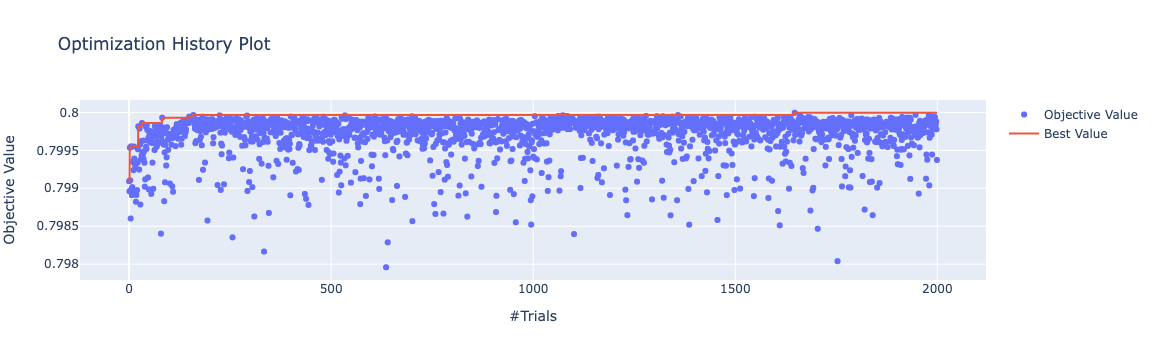

In [20]:
plot_optimization_history(study0)

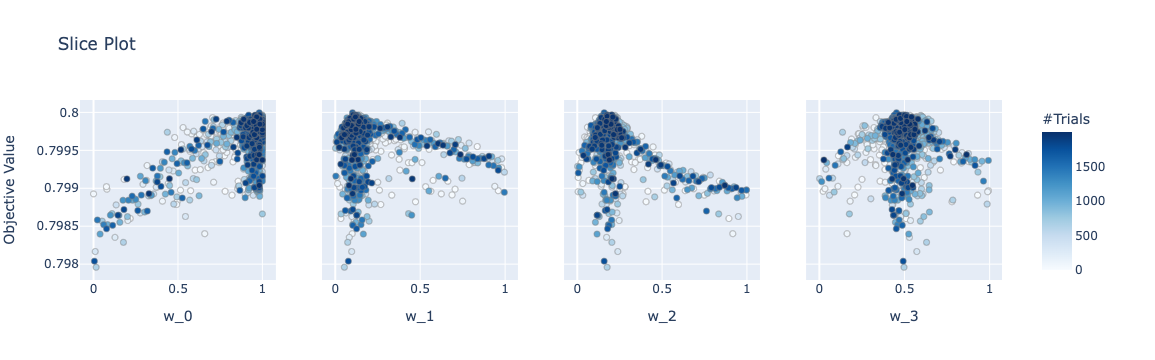

In [21]:
plot_slice(study0)

In [22]:
#plot_param_importances(study0)

In [23]:
weights0 = np.asarray([w for w in study0.best_params.values()])
weights0 /=  weights0.sum()
weights0

array([0.57900455, 0.05999905, 0.093646  , 0.2673504 ])

***

In [24]:
%%time
study1 = compute_optimal_blend(all_dfs, on_cv=1)

CPU times: user 8min 18s, sys: 53 ms, total: 8min 18s
Wall time: 8min 18s


In [25]:
print(compute_amex_metric(df1.target.values, df1.pred1.values))
print(compute_amex_metric(df2.target.values, df2.pred1.values))
print(compute_amex_metric(df4.target.values, df4.pred1.values))
print(compute_amex_metric(df5.target.values, df5.pred1.values))

0.7987974972636289
0.7982647616242418
0.7960625468441459
0.7964928213424268


In [26]:
# max: 0.798215
study1.trials_dataframe().sort_values("value", ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
1948    1948  0.800105 2022-08-17 15:54:39.440416 2022-08-17 15:54:39.569059   
1417    1417  0.800083 2022-08-17 15:52:18.279714 2022-08-17 15:52:18.398733   
1765    1765  0.800075 2022-08-17 15:53:49.861697 2022-08-17 15:53:49.984856   
1732    1732  0.800074 2022-08-17 15:53:41.089471 2022-08-17 15:53:41.213626   
917      917  0.800073 2022-08-17 15:50:11.472985 2022-08-17 15:50:11.579161   
996      996  0.800070 2022-08-17 15:50:31.255608 2022-08-17 15:50:31.363329   
1197    1197  0.800066 2022-08-17 15:51:21.932509 2022-08-17 15:51:22.046434   
1996    1996  0.800061 2022-08-17 15:54:52.484685 2022-08-17 15:54:52.612378   
1842    1842  0.800061 2022-08-17 15:54:10.604375 2022-08-17 15:54:10.728276   
1097    1097  0.800061 2022-08-17 15:50:56.515302 2022-08-17 15:50:56.626125   

                   duration  params_w_0  params_w_1  params_w_2  params_w_3  \
1948 0 days 00:00:00.128643    0.910422    0.038476    0.320275    0.419242   
1417 0 days 00:00:00.119019    0.852912    0.031415    0.299839    0.401098   
1765 0 days 00:00:00.123159    0.923519    0.075110    0.337100    0.454666   
1732 0 days 00:00:00.124155    0.918470    0.067513    0.322162    0.453278   
917  0 days 00:00:00.106176    0.922536    0.059612    0.339780    0.445953   
996  0 days 00:00:00.107721    0.955500    0.028870    0.338418    0.435998   
1197 0 days 00:00:00.113925    0.941949    0.073866    0.334853    0.463679   
1996 0 days 00:00:00.127693    0.893153    0.071459    0.313388    0.449894   
1842 0 days 00:00:00.123901    0.940405    0.069751    0.327226    0.464151   
1097 0 days 00:00:00.110823    0.952363    0.070084    0.331915    0.472015   

         state  
1948  COMPLETE  
1417  COMPLETE  
1765  COMPLETE  
1732  COMPLETE  
917   COMPLETE  
996   COMPLETE  
1197  COMPLETE  
1996  COMPLETE  
1842  COMPLETE  
1097  COMPLETE

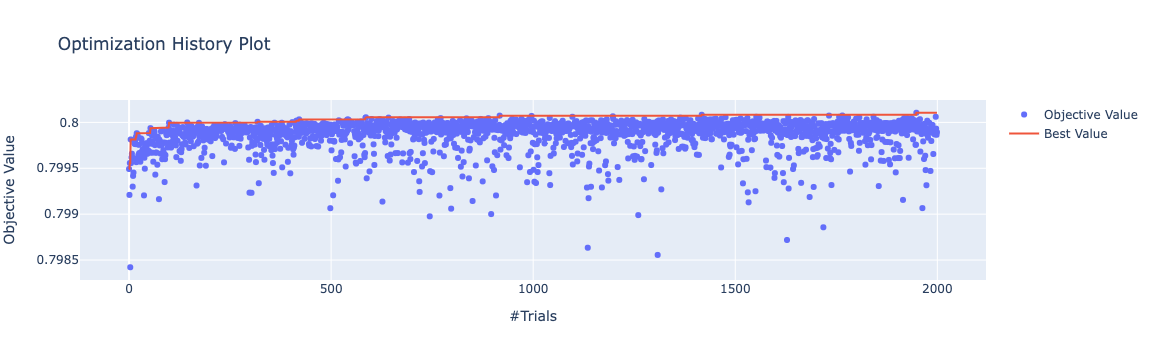

In [27]:
plot_optimization_history(study1)

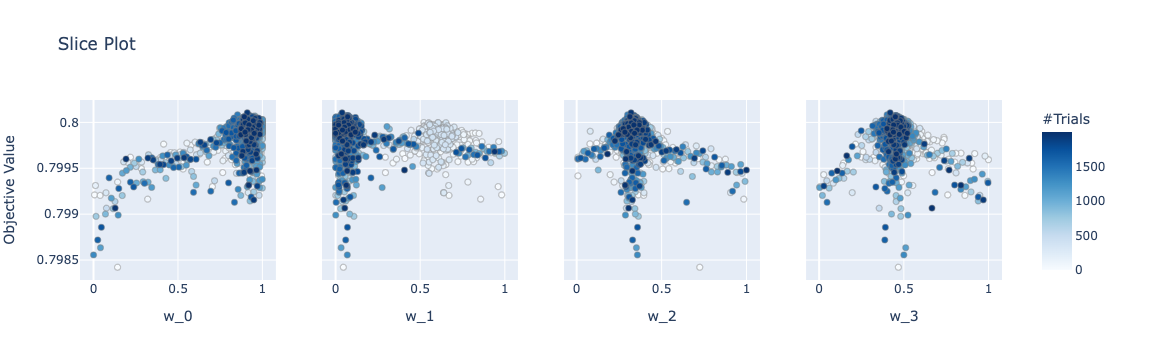

In [28]:
plot_slice(study1)

In [29]:
#plot_param_importances(study1)

In [30]:
weights1 = np.asarray([w for w in study1.best_params.values()])
weights1 /=  weights1.sum()
weights1

array([0.53921659, 0.02278827, 0.18968991, 0.24830523])

***

In [31]:
%%time
study2 = compute_optimal_blend(all_dfs, on_cv=2)

CPU times: user 8min 34s, sys: 131 ms, total: 8min 34s
Wall time: 8min 34s


In [32]:
print(compute_amex_metric(df1.target.values, df1.pred2.values))
print(compute_amex_metric(df2.target.values, df2.pred2.values))
print(compute_amex_metric(df4.target.values, df4.pred2.values))
print(compute_amex_metric(df5.target.values, df5.pred2.values))

0.798232567028073
0.7979193782219492
0.79730897178247
0.7968120935308973


In [33]:
# max: 0.798132
study2.trials_dataframe().sort_values("value", ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
1037    1037  0.799985 2022-08-17 15:59:07.687996 2022-08-17 15:59:07.794888   
1813    1813  0.799983 2022-08-17 16:02:36.136130 2022-08-17 16:02:36.261162   
1860    1860  0.799980 2022-08-17 16:02:49.328066 2022-08-17 16:02:49.453235   
193      193  0.799976 2022-08-17 15:55:39.804185 2022-08-17 15:55:39.897073   
1401    1401  0.799976 2022-08-17 16:00:43.281880 2022-08-17 16:00:43.400134   
1957    1957  0.799974 2022-08-17 16:03:16.744853 2022-08-17 16:03:16.874106   
1866    1866  0.799972 2022-08-17 16:02:51.011447 2022-08-17 16:02:51.138187   
382      382  0.799972 2022-08-17 15:56:24.941246 2022-08-17 15:56:25.035903   
1434    1434  0.799969 2022-08-17 16:00:52.133076 2022-08-17 16:00:52.249656   
1743    1743  0.799967 2022-08-17 16:02:16.587044 2022-08-17 16:02:16.712883   

                   duration  params_w_0  params_w_1  params_w_2  params_w_3  \
1037 0 days 00:00:00.106892    0.782821    0.385245    0.940283    0.216446   
1813 0 days 00:00:00.125032    0.754465    0.425506    0.948709    0.197203   
1860 0 days 00:00:00.125169    0.741105    0.427244    0.950947    0.186845   
193  0 days 00:00:00.092888    0.807887    0.376229    0.936881    0.202471   
1401 0 days 00:00:00.118254    0.793685    0.391264    0.948386    0.208793   
1957 0 days 00:00:00.129253    0.941521    0.443589    0.952753    0.220835   
1866 0 days 00:00:00.126740    0.710555    0.405814    0.907005    0.178811   
382  0 days 00:00:00.094657    0.840892    0.399250    0.998455    0.227271   
1434 0 days 00:00:00.116580    0.842800    0.395354    0.967923    0.211711   
1743 0 days 00:00:00.125839    0.868641    0.429833    0.982943    0.216059   

         state  
1037  COMPLETE  
1813  COMPLETE  
1860  COMPLETE  
193   COMPLETE  
1401  COMPLETE  
1957  COMPLETE  
1866  COMPLETE  
382   COMPLETE  
1434  COMPLETE  
1743  COMPLETE

In [34]:
plot_optimization_history(study2)

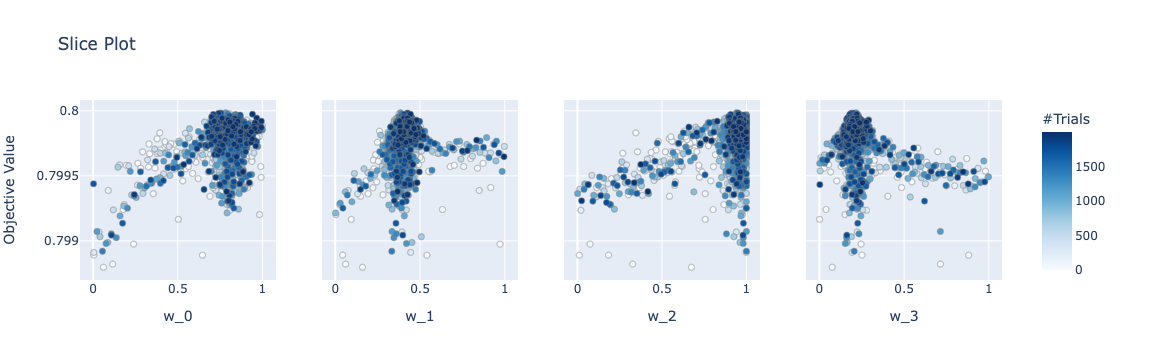

In [35]:
plot_slice(study2)

In [36]:
#plot_param_importances(study2)

In [37]:
weights2 = np.asarray([w for w in study2.best_params.values()])
weights2 /=  weights2.sum()
weights2

array([0.33672706, 0.16571137, 0.40445826, 0.09310331])

***
## blend

In [ ]:
sub1 = pd.read_csv("../data/subs/lgbm-dart-bce-dsv06/submission-all.csv")
sub2 = pd.read_csv("../data/subs/lgbm-dart-xtree-bce-dsv06/submission-all.csv")
sub3 = pd.read_csv("../data/subs/lgbm-dart-linear-bce-dsv06/submission-all.csv")
sub4 = pd.read_csv("../data/subs/xgboost-dsv06/submission-all.csv")
sub5 = pd.read_csv("../data/subs/catboost-dsv06/submission-all.csv")

In [ ]:
preds = np.concatenate([
    sub1.prediction.values.reshape(-1,1),
    sub2.prediction.values.reshape(-1,1),
    #sub3.prediction.values.reshape(-1,1),
    sub4.prediction.values.reshape(-1,1),
    sub5.prediction.values.reshape(-1,1)
    ],
    axis=1
)
preds

In [ ]:
sub = sub1.copy()

blend0 = (preds*weights0).sum(axis=1)
blend1 = (preds*weights1).sum(axis=1)
blend2 = (preds*weights2).sum(axis=1)

sub["prediction"] = np.mean([blend0, blend1, blend2], axis=0)

In [ ]:
sub.to_csv(SUB_PATH/"submission-blend.csv", index=False)

In [ ]:
sub.prediction.describe()

***